<a href="https://colab.research.google.com/github/amita-kapoor/introdeeplearning/blob/master/DCGAN_modified_AK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [2]:


from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

import sys

import numpy as np



In [3]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        optimizer_disc = Adam(0.0001, 0.5)
        optimizer_gen = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer_disc,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/dcgan_mnist_%d.png" % epoch)
        plt.show()
        plt.close()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0

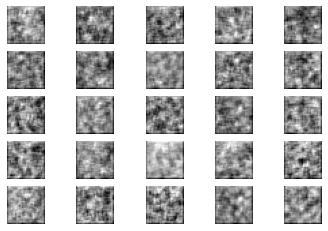

1 [D loss: 0.756024, acc.: 51.56%] [G loss: 0.724195]
2 [D loss: 0.446404, acc.: 80.47%] [G loss: 0.742299]
3 [D loss: 0.359225, acc.: 88.67%] [G loss: 0.727079]
4 [D loss: 0.201872, acc.: 96.09%] [G loss: 0.667504]
5 [D loss: 0.182713, acc.: 97.66%] [G loss: 0.558722]
6 [D loss: 0.137896, acc.: 98.83%] [G loss: 0.467593]
7 [D loss: 0.153273, acc.: 98.05%] [G loss: 0.334088]
8 [D loss: 0.176927, acc.: 96.88%] [G loss: 0.223170]
9 [D loss: 0.210848, acc.: 94.92%] [G loss: 0.197499]
10 [D loss: 0.215138, acc.: 94.92%] [G loss: 0.219087]
11 [D loss: 0.142784, acc.: 98.05%] [G loss: 0.175186]
12 [D loss: 0.096051, acc.: 99.22%] [G loss: 0.148067]
13 [D loss: 0.102354, acc.: 100.00%] [G loss: 0.092405]
14 [D loss: 0.144973, acc.: 98.05%] [G loss: 0.070525]
15 [D loss: 0.181067, acc.: 94.53%] [G loss: 0.071257]
16 [D loss: 0.326189, acc.: 84.38%] [G loss: 0.180288]
17 [D loss: 0.681348, acc.: 60.55%] [G loss: 0.403162]
18 [D loss: 0.898382, acc.: 50.39%] [G loss: 0.705766]
19 [D loss: 0.5040

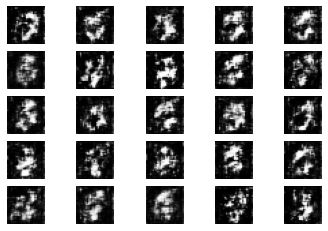

51 [D loss: 0.872520, acc.: 44.14%] [G loss: 1.050426]
52 [D loss: 0.910435, acc.: 44.53%] [G loss: 1.005773]
53 [D loss: 0.879018, acc.: 43.36%] [G loss: 0.903771]
54 [D loss: 0.850773, acc.: 47.27%] [G loss: 0.872629]
55 [D loss: 0.773948, acc.: 50.78%] [G loss: 1.128578]
56 [D loss: 0.799905, acc.: 50.00%] [G loss: 0.892631]
57 [D loss: 0.786230, acc.: 51.56%] [G loss: 1.000855]
58 [D loss: 0.784213, acc.: 50.78%] [G loss: 1.034990]
59 [D loss: 0.778129, acc.: 51.56%] [G loss: 0.982068]
60 [D loss: 0.835730, acc.: 44.14%] [G loss: 1.146570]
61 [D loss: 0.869064, acc.: 44.53%] [G loss: 1.001894]
62 [D loss: 0.850765, acc.: 44.92%] [G loss: 0.945578]
63 [D loss: 0.890512, acc.: 46.48%] [G loss: 1.021790]
64 [D loss: 0.779425, acc.: 55.47%] [G loss: 1.003435]
65 [D loss: 0.704769, acc.: 57.81%] [G loss: 1.104851]
66 [D loss: 0.824806, acc.: 51.95%] [G loss: 1.004004]
67 [D loss: 0.752990, acc.: 54.30%] [G loss: 0.981248]
68 [D loss: 0.847593, acc.: 48.83%] [G loss: 0.958378]
69 [D loss

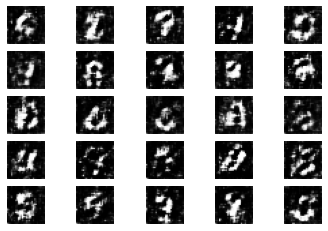

101 [D loss: 0.830744, acc.: 47.66%] [G loss: 0.885897]
102 [D loss: 0.834613, acc.: 47.66%] [G loss: 0.966668]
103 [D loss: 0.856834, acc.: 47.27%] [G loss: 0.946326]
104 [D loss: 0.811952, acc.: 49.61%] [G loss: 0.909195]
105 [D loss: 0.814248, acc.: 48.05%] [G loss: 0.942308]
106 [D loss: 0.820525, acc.: 53.52%] [G loss: 0.911830]
107 [D loss: 0.819698, acc.: 50.39%] [G loss: 0.864722]
108 [D loss: 0.754942, acc.: 47.66%] [G loss: 0.912849]
109 [D loss: 0.763533, acc.: 54.69%] [G loss: 0.850484]
110 [D loss: 0.753328, acc.: 50.78%] [G loss: 0.936171]
111 [D loss: 0.806408, acc.: 50.39%] [G loss: 0.806715]
112 [D loss: 0.753256, acc.: 56.64%] [G loss: 0.865837]
113 [D loss: 0.772648, acc.: 51.56%] [G loss: 0.854051]
114 [D loss: 0.765436, acc.: 51.17%] [G loss: 0.815241]
115 [D loss: 0.795733, acc.: 48.05%] [G loss: 0.814006]
116 [D loss: 0.757816, acc.: 46.88%] [G loss: 0.813183]
117 [D loss: 0.808799, acc.: 49.61%] [G loss: 1.029453]
118 [D loss: 0.770953, acc.: 52.73%] [G loss: 0.

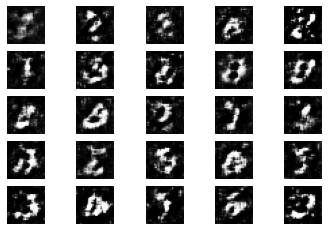

151 [D loss: 0.726366, acc.: 53.91%] [G loss: 0.881573]
152 [D loss: 0.795997, acc.: 48.83%] [G loss: 0.856855]
153 [D loss: 0.759233, acc.: 50.39%] [G loss: 0.890694]
154 [D loss: 0.801799, acc.: 50.39%] [G loss: 0.887351]
155 [D loss: 0.794981, acc.: 48.83%] [G loss: 0.868837]
156 [D loss: 0.813972, acc.: 49.61%] [G loss: 0.857450]
157 [D loss: 0.779990, acc.: 49.61%] [G loss: 0.875058]
158 [D loss: 0.826254, acc.: 43.36%] [G loss: 0.905603]
159 [D loss: 0.766802, acc.: 48.44%] [G loss: 0.976717]
160 [D loss: 0.820589, acc.: 47.27%] [G loss: 0.880015]
161 [D loss: 0.828819, acc.: 45.31%] [G loss: 0.965059]
162 [D loss: 0.818029, acc.: 45.70%] [G loss: 0.997712]
163 [D loss: 0.819469, acc.: 50.78%] [G loss: 0.895996]
164 [D loss: 0.769689, acc.: 51.95%] [G loss: 0.914723]
165 [D loss: 0.815035, acc.: 49.22%] [G loss: 0.901427]
166 [D loss: 0.784412, acc.: 48.44%] [G loss: 0.961877]
167 [D loss: 0.844018, acc.: 44.53%] [G loss: 0.888304]
168 [D loss: 0.797318, acc.: 48.44%] [G loss: 0.

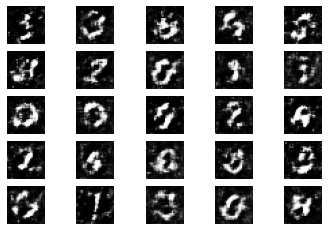

201 [D loss: 0.805712, acc.: 47.27%] [G loss: 0.876243]
202 [D loss: 0.799736, acc.: 44.53%] [G loss: 0.859807]
203 [D loss: 0.816059, acc.: 44.14%] [G loss: 0.907210]
204 [D loss: 0.840779, acc.: 45.70%] [G loss: 0.805446]
205 [D loss: 0.800354, acc.: 49.61%] [G loss: 0.901729]
206 [D loss: 0.834499, acc.: 43.36%] [G loss: 0.947235]
207 [D loss: 0.756971, acc.: 50.39%] [G loss: 0.897285]
208 [D loss: 0.848385, acc.: 43.75%] [G loss: 0.909734]
209 [D loss: 0.904964, acc.: 36.33%] [G loss: 0.898199]
210 [D loss: 0.816624, acc.: 45.31%] [G loss: 0.872701]
211 [D loss: 0.808619, acc.: 49.61%] [G loss: 0.913915]
212 [D loss: 0.766115, acc.: 50.78%] [G loss: 0.893408]
213 [D loss: 0.821495, acc.: 43.75%] [G loss: 0.881183]
214 [D loss: 0.787188, acc.: 51.17%] [G loss: 0.893162]
215 [D loss: 0.769086, acc.: 50.39%] [G loss: 0.907129]
216 [D loss: 0.767102, acc.: 45.31%] [G loss: 0.850844]
217 [D loss: 0.761086, acc.: 49.61%] [G loss: 0.888772]
218 [D loss: 0.749920, acc.: 49.61%] [G loss: 0.

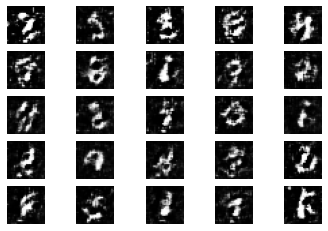

251 [D loss: 0.825518, acc.: 44.14%] [G loss: 0.889773]
252 [D loss: 0.846677, acc.: 41.80%] [G loss: 0.862529]
253 [D loss: 0.811871, acc.: 47.27%] [G loss: 0.857328]
254 [D loss: 0.777523, acc.: 53.52%] [G loss: 0.864835]
255 [D loss: 0.728675, acc.: 53.12%] [G loss: 0.917745]
256 [D loss: 0.724122, acc.: 57.03%] [G loss: 0.913924]
257 [D loss: 0.723498, acc.: 58.98%] [G loss: 0.976030]
258 [D loss: 0.739197, acc.: 52.73%] [G loss: 1.040520]
259 [D loss: 0.755164, acc.: 52.73%] [G loss: 0.954917]
260 [D loss: 0.874481, acc.: 39.06%] [G loss: 0.959702]
261 [D loss: 0.800709, acc.: 45.31%] [G loss: 0.947187]
262 [D loss: 0.859515, acc.: 41.41%] [G loss: 0.976414]
263 [D loss: 0.821387, acc.: 45.70%] [G loss: 0.934897]
264 [D loss: 0.812230, acc.: 48.05%] [G loss: 0.906262]
265 [D loss: 0.748394, acc.: 48.83%] [G loss: 0.914226]
266 [D loss: 0.753246, acc.: 50.00%] [G loss: 0.863280]
267 [D loss: 0.717076, acc.: 58.59%] [G loss: 0.899617]
268 [D loss: 0.825293, acc.: 41.80%] [G loss: 0.

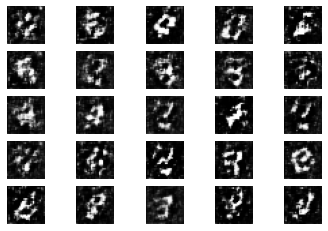

301 [D loss: 0.781530, acc.: 45.70%] [G loss: 0.844815]
302 [D loss: 0.760327, acc.: 53.91%] [G loss: 0.828528]
303 [D loss: 0.798242, acc.: 44.53%] [G loss: 0.838167]
304 [D loss: 0.744021, acc.: 53.12%] [G loss: 0.894258]
305 [D loss: 0.739902, acc.: 53.12%] [G loss: 0.868370]
306 [D loss: 0.719780, acc.: 54.30%] [G loss: 0.813183]
307 [D loss: 0.775604, acc.: 53.12%] [G loss: 0.862266]
308 [D loss: 0.767472, acc.: 52.34%] [G loss: 0.816036]
309 [D loss: 0.772838, acc.: 48.05%] [G loss: 0.904641]
310 [D loss: 0.739271, acc.: 56.64%] [G loss: 0.916102]
311 [D loss: 0.793248, acc.: 45.70%] [G loss: 0.730221]
312 [D loss: 0.744799, acc.: 48.44%] [G loss: 0.840636]
313 [D loss: 0.785356, acc.: 45.31%] [G loss: 0.802466]
314 [D loss: 0.766773, acc.: 51.56%] [G loss: 0.822753]
315 [D loss: 0.753378, acc.: 50.00%] [G loss: 0.806101]
316 [D loss: 0.739443, acc.: 52.73%] [G loss: 0.866627]
317 [D loss: 0.762074, acc.: 45.31%] [G loss: 0.833311]
318 [D loss: 0.706621, acc.: 56.64%] [G loss: 0.

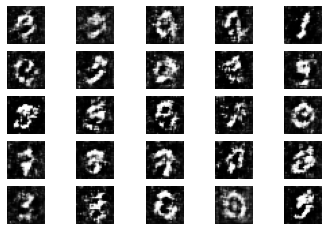

351 [D loss: 0.810520, acc.: 44.53%] [G loss: 0.874828]
352 [D loss: 0.834394, acc.: 44.92%] [G loss: 0.800203]
353 [D loss: 0.811453, acc.: 45.31%] [G loss: 0.724153]
354 [D loss: 0.742326, acc.: 50.39%] [G loss: 0.813260]
355 [D loss: 0.748697, acc.: 51.17%] [G loss: 0.764193]
356 [D loss: 0.740445, acc.: 52.34%] [G loss: 0.812654]
357 [D loss: 0.642363, acc.: 61.72%] [G loss: 0.917627]
358 [D loss: 0.699002, acc.: 55.47%] [G loss: 0.850563]
359 [D loss: 0.684389, acc.: 56.25%] [G loss: 0.884153]
360 [D loss: 0.734780, acc.: 53.52%] [G loss: 0.912341]
361 [D loss: 0.717557, acc.: 54.69%] [G loss: 0.822447]
362 [D loss: 0.712875, acc.: 54.69%] [G loss: 0.866466]
363 [D loss: 0.763515, acc.: 51.17%] [G loss: 0.865031]
364 [D loss: 0.805888, acc.: 44.92%] [G loss: 0.747598]
365 [D loss: 0.777921, acc.: 48.05%] [G loss: 0.910515]
366 [D loss: 0.848090, acc.: 42.58%] [G loss: 0.866308]
367 [D loss: 0.874811, acc.: 35.16%] [G loss: 0.936602]
368 [D loss: 0.747035, acc.: 48.05%] [G loss: 0.

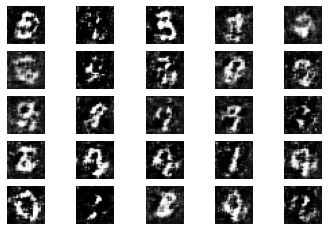

401 [D loss: 0.783219, acc.: 49.61%] [G loss: 0.805673]
402 [D loss: 0.752851, acc.: 48.83%] [G loss: 0.859711]
403 [D loss: 0.737279, acc.: 49.61%] [G loss: 0.770109]
404 [D loss: 0.678532, acc.: 60.16%] [G loss: 0.773888]
405 [D loss: 0.609132, acc.: 67.97%] [G loss: 0.805034]
406 [D loss: 0.596126, acc.: 67.19%] [G loss: 0.807263]
407 [D loss: 0.768608, acc.: 48.05%] [G loss: 0.775973]
408 [D loss: 0.799804, acc.: 50.00%] [G loss: 0.856802]
409 [D loss: 0.711450, acc.: 53.12%] [G loss: 0.867360]
410 [D loss: 0.810121, acc.: 42.58%] [G loss: 0.931199]
411 [D loss: 0.736757, acc.: 48.83%] [G loss: 0.869049]
412 [D loss: 0.797444, acc.: 39.84%] [G loss: 0.838989]
413 [D loss: 0.735588, acc.: 48.83%] [G loss: 0.732693]
414 [D loss: 0.721837, acc.: 53.91%] [G loss: 0.819342]
415 [D loss: 0.701755, acc.: 59.38%] [G loss: 0.767783]
416 [D loss: 0.631165, acc.: 62.50%] [G loss: 0.791540]
417 [D loss: 0.711413, acc.: 56.25%] [G loss: 0.778383]
418 [D loss: 0.714872, acc.: 53.91%] [G loss: 0.

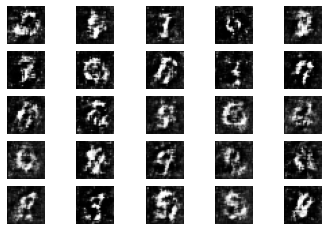

451 [D loss: 0.711864, acc.: 55.47%] [G loss: 0.832641]
452 [D loss: 0.607519, acc.: 67.97%] [G loss: 0.786988]
453 [D loss: 0.664111, acc.: 64.06%] [G loss: 0.826753]
454 [D loss: 0.663472, acc.: 61.72%] [G loss: 0.844299]
455 [D loss: 0.740989, acc.: 53.12%] [G loss: 0.886540]
456 [D loss: 0.856805, acc.: 43.75%] [G loss: 0.807503]
457 [D loss: 0.767326, acc.: 45.70%] [G loss: 0.879590]
458 [D loss: 0.725846, acc.: 53.91%] [G loss: 0.902704]
459 [D loss: 0.735233, acc.: 53.12%] [G loss: 0.860915]
460 [D loss: 0.758396, acc.: 49.61%] [G loss: 0.814857]
461 [D loss: 0.724200, acc.: 53.91%] [G loss: 0.767640]
462 [D loss: 0.765868, acc.: 51.95%] [G loss: 0.798664]
463 [D loss: 0.744566, acc.: 50.78%] [G loss: 0.823887]
464 [D loss: 0.762277, acc.: 52.73%] [G loss: 0.811797]
465 [D loss: 0.717295, acc.: 57.81%] [G loss: 0.783469]
466 [D loss: 0.692743, acc.: 55.08%] [G loss: 0.891198]
467 [D loss: 0.683898, acc.: 57.03%] [G loss: 0.908005]
468 [D loss: 0.693624, acc.: 59.38%] [G loss: 0.

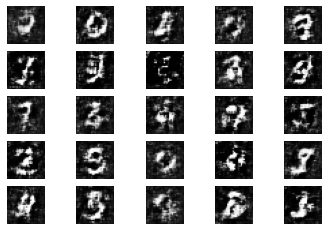

501 [D loss: 0.812572, acc.: 44.92%] [G loss: 0.913698]
502 [D loss: 0.703886, acc.: 52.73%] [G loss: 0.833453]
503 [D loss: 0.769018, acc.: 53.12%] [G loss: 0.850296]
504 [D loss: 0.727695, acc.: 54.30%] [G loss: 0.837783]
505 [D loss: 0.822067, acc.: 42.19%] [G loss: 0.784598]
506 [D loss: 0.806525, acc.: 44.92%] [G loss: 0.843369]
507 [D loss: 0.715211, acc.: 53.91%] [G loss: 0.792311]
508 [D loss: 0.765743, acc.: 50.00%] [G loss: 0.769495]
509 [D loss: 0.695579, acc.: 60.94%] [G loss: 0.856770]
510 [D loss: 0.633051, acc.: 64.84%] [G loss: 0.817853]
511 [D loss: 0.618919, acc.: 66.41%] [G loss: 0.827888]
512 [D loss: 0.626542, acc.: 66.02%] [G loss: 0.831189]
513 [D loss: 0.687531, acc.: 59.38%] [G loss: 0.899449]
514 [D loss: 0.610164, acc.: 66.02%] [G loss: 0.845065]
515 [D loss: 0.645055, acc.: 63.67%] [G loss: 0.862568]
516 [D loss: 0.806475, acc.: 48.05%] [G loss: 0.842445]
517 [D loss: 0.845762, acc.: 43.36%] [G loss: 0.839776]
518 [D loss: 0.819923, acc.: 45.70%] [G loss: 0.

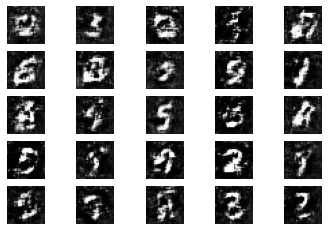

551 [D loss: 0.781114, acc.: 46.88%] [G loss: 0.804697]
552 [D loss: 0.717611, acc.: 55.47%] [G loss: 0.865926]
553 [D loss: 0.705243, acc.: 56.64%] [G loss: 0.881741]
554 [D loss: 0.745583, acc.: 52.73%] [G loss: 0.895100]
555 [D loss: 0.736143, acc.: 54.30%] [G loss: 0.850549]
556 [D loss: 0.682999, acc.: 59.38%] [G loss: 0.764407]
557 [D loss: 0.664087, acc.: 64.06%] [G loss: 0.810733]
558 [D loss: 0.623771, acc.: 63.28%] [G loss: 0.778248]
559 [D loss: 0.707412, acc.: 56.64%] [G loss: 0.803803]
560 [D loss: 0.551428, acc.: 71.88%] [G loss: 0.819351]
561 [D loss: 0.654081, acc.: 59.38%] [G loss: 0.884467]
562 [D loss: 0.663750, acc.: 58.20%] [G loss: 0.883998]
563 [D loss: 0.625959, acc.: 63.67%] [G loss: 0.883264]
564 [D loss: 0.672785, acc.: 60.55%] [G loss: 0.844724]
565 [D loss: 0.558380, acc.: 71.88%] [G loss: 0.768555]
566 [D loss: 0.771369, acc.: 48.44%] [G loss: 0.821782]
567 [D loss: 0.684209, acc.: 57.42%] [G loss: 0.829855]
568 [D loss: 0.817587, acc.: 44.53%] [G loss: 0.

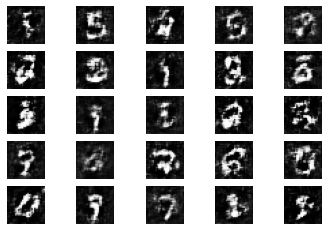

601 [D loss: 0.570616, acc.: 70.70%] [G loss: 0.838485]
602 [D loss: 0.525208, acc.: 75.39%] [G loss: 0.806005]
603 [D loss: 0.523775, acc.: 76.56%] [G loss: 0.796037]
604 [D loss: 0.693055, acc.: 54.69%] [G loss: 0.804201]
605 [D loss: 0.831306, acc.: 47.27%] [G loss: 0.829747]
606 [D loss: 0.906354, acc.: 35.55%] [G loss: 0.884844]
607 [D loss: 0.998076, acc.: 28.52%] [G loss: 0.998997]
608 [D loss: 0.822088, acc.: 42.19%] [G loss: 0.911774]
609 [D loss: 0.802218, acc.: 48.05%] [G loss: 0.907701]
610 [D loss: 0.635299, acc.: 64.84%] [G loss: 0.820861]
611 [D loss: 0.459355, acc.: 79.69%] [G loss: 0.749730]
612 [D loss: 0.426354, acc.: 85.55%] [G loss: 0.706788]
613 [D loss: 0.513792, acc.: 78.12%] [G loss: 0.748605]
614 [D loss: 0.656805, acc.: 62.11%] [G loss: 0.764877]
615 [D loss: 0.649603, acc.: 62.50%] [G loss: 0.876154]
616 [D loss: 0.693794, acc.: 59.38%] [G loss: 0.993082]
617 [D loss: 0.791895, acc.: 46.09%] [G loss: 0.928177]
618 [D loss: 0.693816, acc.: 55.86%] [G loss: 0.

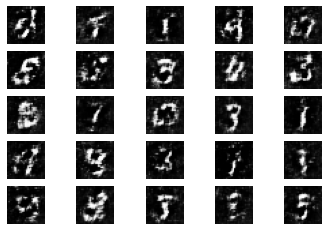

651 [D loss: 0.368275, acc.: 89.84%] [G loss: 0.775654]
652 [D loss: 0.500416, acc.: 77.34%] [G loss: 0.800980]
653 [D loss: 0.649781, acc.: 60.16%] [G loss: 0.783903]
654 [D loss: 0.715947, acc.: 58.98%] [G loss: 0.898514]
655 [D loss: 0.949219, acc.: 29.30%] [G loss: 0.911486]
656 [D loss: 0.741524, acc.: 53.12%] [G loss: 0.964438]
657 [D loss: 0.682604, acc.: 57.03%] [G loss: 0.823922]
658 [D loss: 0.743685, acc.: 50.39%] [G loss: 0.810891]
659 [D loss: 0.599165, acc.: 71.88%] [G loss: 0.877246]
660 [D loss: 0.750255, acc.: 50.78%] [G loss: 0.802216]
661 [D loss: 0.704863, acc.: 56.64%] [G loss: 0.803747]
662 [D loss: 0.644065, acc.: 61.33%] [G loss: 0.877116]
663 [D loss: 0.641118, acc.: 63.67%] [G loss: 0.808355]
664 [D loss: 0.733293, acc.: 54.69%] [G loss: 0.787216]
665 [D loss: 0.579099, acc.: 71.88%] [G loss: 0.901037]
666 [D loss: 0.685628, acc.: 57.42%] [G loss: 0.862085]
667 [D loss: 0.675996, acc.: 58.98%] [G loss: 0.790411]
668 [D loss: 0.656426, acc.: 62.50%] [G loss: 0.

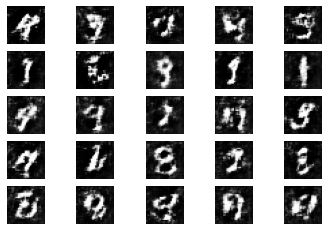

701 [D loss: 0.883791, acc.: 36.33%] [G loss: 0.853183]
702 [D loss: 0.801255, acc.: 47.27%] [G loss: 0.901525]
703 [D loss: 0.746001, acc.: 49.22%] [G loss: 0.896954]
704 [D loss: 0.629107, acc.: 67.58%] [G loss: 0.906035]
705 [D loss: 0.628690, acc.: 65.23%] [G loss: 0.804083]
706 [D loss: 0.644835, acc.: 62.89%] [G loss: 0.834618]
707 [D loss: 0.452406, acc.: 81.25%] [G loss: 0.772047]
708 [D loss: 0.508140, acc.: 75.00%] [G loss: 0.809990]
709 [D loss: 0.574864, acc.: 70.70%] [G loss: 0.845789]
710 [D loss: 0.598109, acc.: 68.75%] [G loss: 0.816722]
711 [D loss: 0.723085, acc.: 56.64%] [G loss: 0.893375]
712 [D loss: 0.804932, acc.: 50.78%] [G loss: 0.926755]
713 [D loss: 1.015104, acc.: 25.78%] [G loss: 0.999402]
714 [D loss: 0.877677, acc.: 36.72%] [G loss: 0.933629]
715 [D loss: 0.740750, acc.: 50.39%] [G loss: 0.931622]
716 [D loss: 0.590041, acc.: 69.53%] [G loss: 0.830597]
717 [D loss: 0.601543, acc.: 67.97%] [G loss: 0.785312]
718 [D loss: 0.481204, acc.: 81.25%] [G loss: 0.

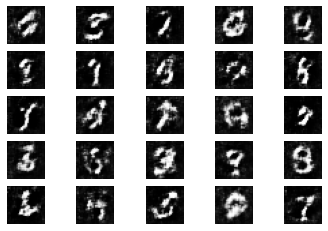

751 [D loss: 0.623601, acc.: 63.28%] [G loss: 0.814373]
752 [D loss: 0.755772, acc.: 55.47%] [G loss: 0.839570]
753 [D loss: 0.796546, acc.: 46.88%] [G loss: 0.917409]
754 [D loss: 0.802318, acc.: 46.88%] [G loss: 0.996920]
755 [D loss: 0.814180, acc.: 43.75%] [G loss: 0.877864]
756 [D loss: 0.655747, acc.: 60.55%] [G loss: 0.827609]
757 [D loss: 0.465660, acc.: 82.42%] [G loss: 0.848437]
758 [D loss: 0.580991, acc.: 68.36%] [G loss: 0.781905]
759 [D loss: 0.507419, acc.: 81.64%] [G loss: 0.781155]
760 [D loss: 0.726067, acc.: 52.73%] [G loss: 0.851907]
761 [D loss: 0.649643, acc.: 59.38%] [G loss: 0.860354]
762 [D loss: 0.869341, acc.: 40.62%] [G loss: 0.856803]
763 [D loss: 0.937730, acc.: 35.55%] [G loss: 0.837887]
764 [D loss: 0.679948, acc.: 60.16%] [G loss: 0.836586]
765 [D loss: 0.607822, acc.: 66.80%] [G loss: 0.862343]
766 [D loss: 0.591048, acc.: 69.53%] [G loss: 0.773845]
767 [D loss: 0.704495, acc.: 57.81%] [G loss: 0.880214]
768 [D loss: 0.604192, acc.: 68.75%] [G loss: 0.

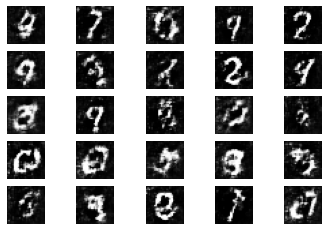

801 [D loss: 0.502137, acc.: 80.08%] [G loss: 0.738179]
802 [D loss: 0.536449, acc.: 75.39%] [G loss: 0.803542]
803 [D loss: 0.540262, acc.: 73.05%] [G loss: 0.837993]
804 [D loss: 0.425291, acc.: 80.86%] [G loss: 0.869657]
805 [D loss: 0.420145, acc.: 84.38%] [G loss: 0.822539]
806 [D loss: 0.544523, acc.: 74.22%] [G loss: 0.883826]
807 [D loss: 0.705002, acc.: 61.72%] [G loss: 0.874948]
808 [D loss: 0.580231, acc.: 69.14%] [G loss: 0.993216]
809 [D loss: 0.867924, acc.: 41.02%] [G loss: 0.972926]
810 [D loss: 0.960528, acc.: 31.64%] [G loss: 0.903220]
811 [D loss: 0.857450, acc.: 42.58%] [G loss: 0.893140]
812 [D loss: 0.909306, acc.: 35.55%] [G loss: 0.866847]
813 [D loss: 0.521381, acc.: 76.17%] [G loss: 0.775645]
814 [D loss: 0.484762, acc.: 76.17%] [G loss: 0.792971]
815 [D loss: 0.418937, acc.: 86.33%] [G loss: 0.770742]
816 [D loss: 0.524907, acc.: 74.22%] [G loss: 0.830938]
817 [D loss: 0.579770, acc.: 71.48%] [G loss: 0.832374]
818 [D loss: 0.891535, acc.: 43.36%] [G loss: 0.

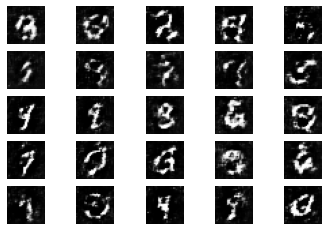

851 [D loss: 0.361129, acc.: 89.84%] [G loss: 0.851740]
852 [D loss: 0.722553, acc.: 57.03%] [G loss: 0.868624]
853 [D loss: 0.507749, acc.: 79.69%] [G loss: 0.977021]
854 [D loss: 1.053143, acc.: 30.47%] [G loss: 0.902302]
855 [D loss: 0.916409, acc.: 38.67%] [G loss: 0.951083]
856 [D loss: 0.888114, acc.: 38.28%] [G loss: 0.967151]
857 [D loss: 0.615549, acc.: 65.62%] [G loss: 0.795500]
858 [D loss: 0.669845, acc.: 62.11%] [G loss: 0.882887]
859 [D loss: 0.514494, acc.: 76.95%] [G loss: 0.838284]
860 [D loss: 0.507310, acc.: 78.52%] [G loss: 0.822116]
861 [D loss: 0.523746, acc.: 76.95%] [G loss: 0.950459]
862 [D loss: 0.658914, acc.: 61.33%] [G loss: 0.840008]
863 [D loss: 0.675492, acc.: 57.03%] [G loss: 0.914593]
864 [D loss: 0.755558, acc.: 47.27%] [G loss: 0.931855]
865 [D loss: 0.956242, acc.: 32.81%] [G loss: 0.984674]
866 [D loss: 0.920773, acc.: 32.03%] [G loss: 0.998113]
867 [D loss: 0.564405, acc.: 69.14%] [G loss: 1.011533]
868 [D loss: 0.685426, acc.: 58.98%] [G loss: 0.

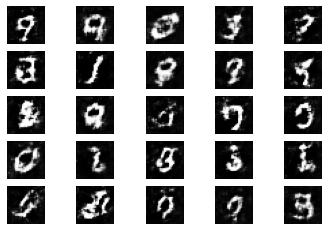

901 [D loss: 0.924412, acc.: 35.55%] [G loss: 0.895214]
902 [D loss: 0.700681, acc.: 54.69%] [G loss: 0.885733]
903 [D loss: 0.485502, acc.: 77.73%] [G loss: 0.832951]
904 [D loss: 0.521168, acc.: 76.95%] [G loss: 0.771517]
905 [D loss: 0.363666, acc.: 90.23%] [G loss: 0.812406]
906 [D loss: 0.457511, acc.: 82.81%] [G loss: 0.843178]
907 [D loss: 0.745880, acc.: 57.81%] [G loss: 0.918964]
908 [D loss: 0.501441, acc.: 78.91%] [G loss: 0.854979]
909 [D loss: 0.506053, acc.: 78.52%] [G loss: 0.985538]
910 [D loss: 0.531052, acc.: 72.27%] [G loss: 0.944569]
911 [D loss: 0.955287, acc.: 37.89%] [G loss: 0.745551]
912 [D loss: 0.665149, acc.: 62.50%] [G loss: 0.890183]
913 [D loss: 0.759865, acc.: 54.69%] [G loss: 0.968674]
914 [D loss: 0.721679, acc.: 57.42%] [G loss: 0.992316]
915 [D loss: 0.553688, acc.: 67.97%] [G loss: 0.806520]
916 [D loss: 0.358266, acc.: 89.45%] [G loss: 0.768657]
917 [D loss: 0.728031, acc.: 57.81%] [G loss: 0.801106]
918 [D loss: 0.952066, acc.: 34.38%] [G loss: 0.

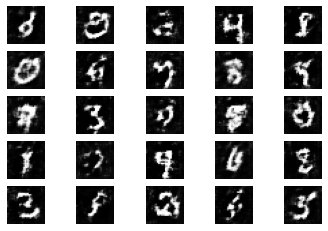

951 [D loss: 0.564449, acc.: 72.66%] [G loss: 0.853500]
952 [D loss: 0.632584, acc.: 65.23%] [G loss: 0.885952]
953 [D loss: 0.743563, acc.: 52.34%] [G loss: 0.907910]
954 [D loss: 0.680494, acc.: 55.47%] [G loss: 0.950064]
955 [D loss: 1.031813, acc.: 30.86%] [G loss: 0.859150]
956 [D loss: 0.863626, acc.: 42.58%] [G loss: 0.899962]
957 [D loss: 0.450828, acc.: 83.20%] [G loss: 0.991081]
958 [D loss: 0.730121, acc.: 56.25%] [G loss: 0.962306]
959 [D loss: 0.784073, acc.: 46.48%] [G loss: 0.831618]
960 [D loss: 0.396828, acc.: 87.50%] [G loss: 0.898447]
961 [D loss: 0.457946, acc.: 82.81%] [G loss: 0.813716]
962 [D loss: 0.563433, acc.: 72.27%] [G loss: 0.854879]
963 [D loss: 0.368777, acc.: 87.89%] [G loss: 0.917767]
964 [D loss: 0.451453, acc.: 82.03%] [G loss: 0.867581]
965 [D loss: 0.502167, acc.: 74.22%] [G loss: 0.853246]
966 [D loss: 1.011778, acc.: 37.89%] [G loss: 0.907667]
967 [D loss: 0.843517, acc.: 41.41%] [G loss: 1.028063]
968 [D loss: 0.400488, acc.: 80.47%] [G loss: 1.

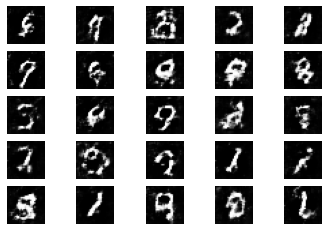

1001 [D loss: 0.638614, acc.: 63.67%] [G loss: 0.809393]
1002 [D loss: 0.553268, acc.: 71.48%] [G loss: 0.799897]
1003 [D loss: 0.576863, acc.: 70.31%] [G loss: 0.895504]
1004 [D loss: 0.515219, acc.: 78.91%] [G loss: 0.861181]
1005 [D loss: 0.615937, acc.: 65.23%] [G loss: 0.926639]
1006 [D loss: 0.793249, acc.: 48.83%] [G loss: 0.958702]
1007 [D loss: 0.532736, acc.: 73.83%] [G loss: 0.867150]
1008 [D loss: 0.358858, acc.: 87.50%] [G loss: 0.865011]
1009 [D loss: 0.436165, acc.: 83.98%] [G loss: 0.931642]
1010 [D loss: 0.263428, acc.: 93.36%] [G loss: 0.924665]
1011 [D loss: 0.367637, acc.: 89.45%] [G loss: 0.890030]
1012 [D loss: 0.326694, acc.: 91.41%] [G loss: 0.858540]
1013 [D loss: 0.282449, acc.: 94.14%] [G loss: 0.903744]
1014 [D loss: 0.456843, acc.: 79.69%] [G loss: 0.898276]
1015 [D loss: 0.424806, acc.: 83.59%] [G loss: 0.953479]
1016 [D loss: 0.626812, acc.: 62.11%] [G loss: 0.935133]
1017 [D loss: 0.717518, acc.: 60.55%] [G loss: 0.909230]
1018 [D loss: 0.777646, acc.: 5

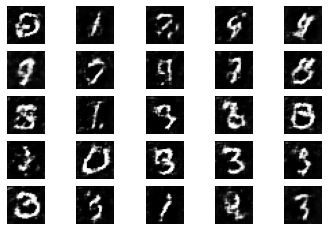

1051 [D loss: 0.204700, acc.: 98.83%] [G loss: 0.836324]
1052 [D loss: 0.375690, acc.: 87.50%] [G loss: 0.927808]
1053 [D loss: 0.454305, acc.: 81.64%] [G loss: 0.822806]
1054 [D loss: 0.897508, acc.: 42.97%] [G loss: 0.827596]
1055 [D loss: 0.765598, acc.: 53.52%] [G loss: 0.839730]
1056 [D loss: 0.659524, acc.: 60.55%] [G loss: 0.885360]
1057 [D loss: 0.665530, acc.: 59.38%] [G loss: 0.962037]
1058 [D loss: 0.592591, acc.: 69.14%] [G loss: 0.881494]
1059 [D loss: 0.610900, acc.: 63.28%] [G loss: 0.880240]
1060 [D loss: 0.419935, acc.: 87.89%] [G loss: 0.842225]
1061 [D loss: 0.369071, acc.: 91.02%] [G loss: 0.807850]
1062 [D loss: 0.367336, acc.: 83.98%] [G loss: 0.937428]
1063 [D loss: 0.395044, acc.: 85.55%] [G loss: 0.875845]
1064 [D loss: 0.323857, acc.: 91.80%] [G loss: 0.846682]
1065 [D loss: 0.452429, acc.: 80.47%] [G loss: 0.871137]
1066 [D loss: 0.492664, acc.: 76.17%] [G loss: 0.955300]
1067 [D loss: 0.982941, acc.: 43.36%] [G loss: 0.792875]
1068 [D loss: 0.466119, acc.: 8

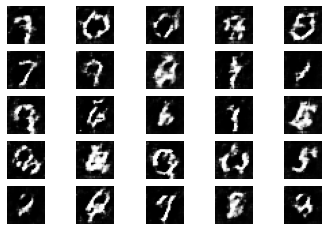

1101 [D loss: 0.543312, acc.: 73.44%] [G loss: 0.852861]
1102 [D loss: 0.789847, acc.: 52.73%] [G loss: 0.828624]
1103 [D loss: 0.845342, acc.: 41.02%] [G loss: 0.827043]
1104 [D loss: 0.892575, acc.: 39.06%] [G loss: 0.942120]
1105 [D loss: 0.724327, acc.: 53.12%] [G loss: 0.872775]
1106 [D loss: 0.518688, acc.: 76.95%] [G loss: 0.896910]
1107 [D loss: 0.670973, acc.: 57.81%] [G loss: 1.067800]
1108 [D loss: 0.459090, acc.: 79.69%] [G loss: 0.852840]
1109 [D loss: 0.080438, acc.: 100.00%] [G loss: 0.892414]
1110 [D loss: 0.084443, acc.: 100.00%] [G loss: 0.792680]
1111 [D loss: 0.136159, acc.: 99.22%] [G loss: 0.791006]
1112 [D loss: 0.148111, acc.: 98.05%] [G loss: 0.839320]
1113 [D loss: 0.221960, acc.: 97.66%] [G loss: 0.917395]
1114 [D loss: 0.068490, acc.: 100.00%] [G loss: 0.852522]
1115 [D loss: 0.289833, acc.: 87.50%] [G loss: 0.706771]
1116 [D loss: 0.463335, acc.: 75.78%] [G loss: 0.774599]
1117 [D loss: 0.719988, acc.: 53.91%] [G loss: 0.855382]
1118 [D loss: 0.616675, acc.

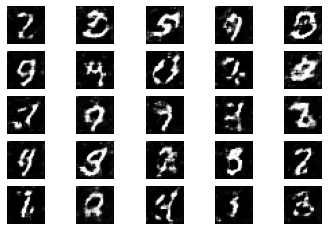

1151 [D loss: 0.515086, acc.: 75.78%] [G loss: 0.979982]
1152 [D loss: 0.340940, acc.: 89.84%] [G loss: 0.966359]
1153 [D loss: 0.636874, acc.: 66.02%] [G loss: 0.871727]
1154 [D loss: 0.355393, acc.: 92.58%] [G loss: 0.810833]
1155 [D loss: 0.484195, acc.: 78.52%] [G loss: 0.815359]
1156 [D loss: 0.383693, acc.: 85.16%] [G loss: 0.805300]
1157 [D loss: 0.659411, acc.: 60.94%] [G loss: 0.918739]
1158 [D loss: 0.990458, acc.: 30.86%] [G loss: 0.905085]
1159 [D loss: 1.175997, acc.: 23.83%] [G loss: 0.913100]
1160 [D loss: 1.190945, acc.: 17.97%] [G loss: 0.953311]
1161 [D loss: 0.512542, acc.: 76.56%] [G loss: 0.998340]
1162 [D loss: 0.663060, acc.: 60.16%] [G loss: 0.863485]
1163 [D loss: 0.176184, acc.: 97.66%] [G loss: 0.884005]
1164 [D loss: 0.328923, acc.: 91.02%] [G loss: 0.813607]
1165 [D loss: 0.500774, acc.: 79.30%] [G loss: 0.884473]
1166 [D loss: 0.508832, acc.: 77.73%] [G loss: 0.925325]
1167 [D loss: 0.968026, acc.: 38.67%] [G loss: 0.838689]
1168 [D loss: 0.381116, acc.: 8

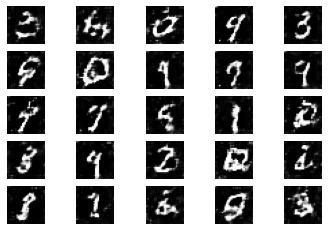

1201 [D loss: 0.175257, acc.: 98.83%] [G loss: 0.846353]
1202 [D loss: 0.131279, acc.: 98.83%] [G loss: 0.850810]
1203 [D loss: 0.389760, acc.: 85.94%] [G loss: 0.876216]
1204 [D loss: 0.152596, acc.: 99.22%] [G loss: 0.846940]
1205 [D loss: 0.215216, acc.: 97.27%] [G loss: 0.841899]
1206 [D loss: 0.183328, acc.: 96.48%] [G loss: 0.753086]
1207 [D loss: 0.467200, acc.: 78.91%] [G loss: 0.795394]
1208 [D loss: 0.307475, acc.: 91.41%] [G loss: 0.908723]
1209 [D loss: 0.487119, acc.: 81.64%] [G loss: 0.875736]
1210 [D loss: 0.351283, acc.: 90.23%] [G loss: 0.936341]
1211 [D loss: 0.801688, acc.: 51.17%] [G loss: 0.909663]
1212 [D loss: 0.422968, acc.: 83.59%] [G loss: 0.944121]
1213 [D loss: 0.609788, acc.: 65.23%] [G loss: 0.943946]
1214 [D loss: 0.802645, acc.: 46.88%] [G loss: 0.943838]
1215 [D loss: 0.465528, acc.: 77.34%] [G loss: 0.866128]
1216 [D loss: 0.389708, acc.: 85.55%] [G loss: 0.871366]
1217 [D loss: 0.381257, acc.: 87.11%] [G loss: 0.941446]
1218 [D loss: 0.646290, acc.: 6

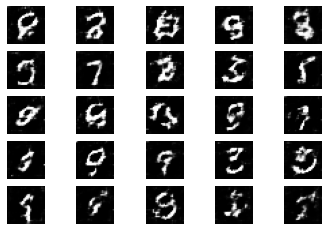

1251 [D loss: 0.232867, acc.: 94.14%] [G loss: 0.968353]
1252 [D loss: 0.146391, acc.: 98.83%] [G loss: 0.909048]
1253 [D loss: 0.429138, acc.: 81.64%] [G loss: 0.868933]
1254 [D loss: 1.115131, acc.: 29.30%] [G loss: 0.831889]
1255 [D loss: 0.356804, acc.: 84.38%] [G loss: 1.045066]
1256 [D loss: 0.322282, acc.: 88.67%] [G loss: 0.922733]
1257 [D loss: 0.317126, acc.: 91.80%] [G loss: 0.968742]
1258 [D loss: 0.309134, acc.: 91.80%] [G loss: 0.888018]
1259 [D loss: 0.075374, acc.: 100.00%] [G loss: 1.078977]
1260 [D loss: 0.224142, acc.: 92.19%] [G loss: 1.022538]
1261 [D loss: 0.175272, acc.: 97.27%] [G loss: 0.848187]
1262 [D loss: 0.439511, acc.: 76.56%] [G loss: 0.844149]
1263 [D loss: 0.221355, acc.: 96.09%] [G loss: 0.925411]
1264 [D loss: 0.649122, acc.: 62.50%] [G loss: 0.875902]
1265 [D loss: 0.529943, acc.: 70.70%] [G loss: 0.854621]
1266 [D loss: 0.347605, acc.: 91.80%] [G loss: 0.946911]
1267 [D loss: 0.401939, acc.: 76.95%] [G loss: 0.983990]
1268 [D loss: 0.535715, acc.: 

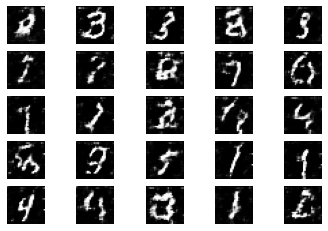

1301 [D loss: 0.169028, acc.: 98.05%] [G loss: 0.798984]
1302 [D loss: 0.491660, acc.: 76.95%] [G loss: 0.825217]
1303 [D loss: 0.240547, acc.: 92.19%] [G loss: 0.997610]
1304 [D loss: 0.368560, acc.: 86.72%] [G loss: 0.843191]
1305 [D loss: 0.411449, acc.: 85.55%] [G loss: 0.884877]
1306 [D loss: 0.212657, acc.: 97.27%] [G loss: 0.942540]
1307 [D loss: 0.335801, acc.: 90.23%] [G loss: 0.839035]
1308 [D loss: 0.142661, acc.: 98.05%] [G loss: 1.068699]
1309 [D loss: 0.525686, acc.: 75.39%] [G loss: 0.902516]
1310 [D loss: 0.296125, acc.: 91.02%] [G loss: 0.943787]
1311 [D loss: 0.804521, acc.: 53.52%] [G loss: 0.951976]
1312 [D loss: 0.661930, acc.: 63.67%] [G loss: 0.996103]
1313 [D loss: 1.653920, acc.: 8.20%] [G loss: 0.883636]
1314 [D loss: 0.773239, acc.: 54.30%] [G loss: 0.914080]
1315 [D loss: 0.521326, acc.: 68.75%] [G loss: 1.143756]
1316 [D loss: 0.681033, acc.: 60.16%] [G loss: 0.942640]
1317 [D loss: 0.165705, acc.: 96.48%] [G loss: 0.723971]
1318 [D loss: 0.072254, acc.: 99

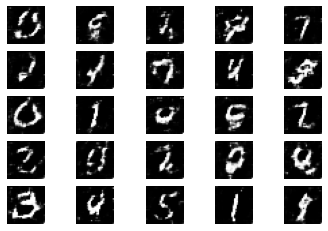

1351 [D loss: 0.214472, acc.: 95.70%] [G loss: 1.075220]
1352 [D loss: 0.144171, acc.: 99.22%] [G loss: 0.986004]
1353 [D loss: 0.431097, acc.: 84.38%] [G loss: 0.949382]
1354 [D loss: 0.288025, acc.: 93.75%] [G loss: 0.891275]
1355 [D loss: 0.613461, acc.: 65.23%] [G loss: 0.901326]
1356 [D loss: 0.264405, acc.: 92.19%] [G loss: 1.022336]
1357 [D loss: 0.495350, acc.: 75.00%] [G loss: 0.942710]
1358 [D loss: 0.627442, acc.: 65.62%] [G loss: 0.828354]
1359 [D loss: 0.264400, acc.: 92.19%] [G loss: 0.994825]
1360 [D loss: 0.354765, acc.: 89.06%] [G loss: 0.911118]
1361 [D loss: 0.288650, acc.: 92.58%] [G loss: 0.959177]
1362 [D loss: 0.497032, acc.: 76.56%] [G loss: 0.934726]
1363 [D loss: 0.675467, acc.: 61.33%] [G loss: 0.770896]
1364 [D loss: 0.469124, acc.: 80.47%] [G loss: 0.963915]
1365 [D loss: 0.805442, acc.: 47.27%] [G loss: 0.845392]
1366 [D loss: 0.490929, acc.: 80.08%] [G loss: 0.936074]
1367 [D loss: 1.189845, acc.: 22.66%] [G loss: 0.899944]
1368 [D loss: 0.589938, acc.: 6

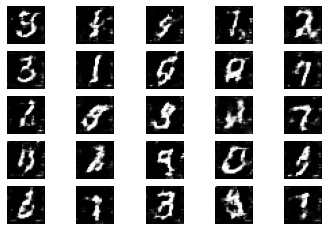

1401 [D loss: 0.223568, acc.: 96.88%] [G loss: 0.944465]
1402 [D loss: 0.575761, acc.: 70.31%] [G loss: 0.811373]
1403 [D loss: 0.216694, acc.: 97.66%] [G loss: 0.934868]
1404 [D loss: 0.405326, acc.: 87.89%] [G loss: 0.897833]
1405 [D loss: 0.272674, acc.: 95.31%] [G loss: 0.939823]
1406 [D loss: 0.559547, acc.: 71.48%] [G loss: 0.890981]
1407 [D loss: 0.304431, acc.: 87.11%] [G loss: 1.117084]
1408 [D loss: 0.266979, acc.: 92.97%] [G loss: 1.080877]
1409 [D loss: 0.187199, acc.: 98.05%] [G loss: 1.020142]
1410 [D loss: 0.039462, acc.: 100.00%] [G loss: 1.130206]
1411 [D loss: 0.464853, acc.: 76.56%] [G loss: 1.093349]
1412 [D loss: 0.113103, acc.: 98.44%] [G loss: 0.863180]
1413 [D loss: 0.058034, acc.: 99.22%] [G loss: 0.913701]
1414 [D loss: 0.075984, acc.: 99.61%] [G loss: 1.065087]
1415 [D loss: 0.106552, acc.: 100.00%] [G loss: 0.808870]
1416 [D loss: 0.052092, acc.: 100.00%] [G loss: 0.979889]
1417 [D loss: 0.155551, acc.: 97.27%] [G loss: 0.809297]
1418 [D loss: 0.570021, acc.

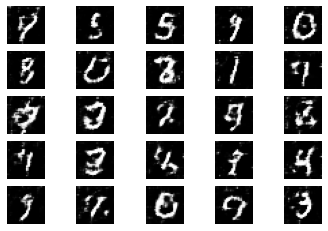

1451 [D loss: 1.290416, acc.: 50.00%] [G loss: 1.119097]
1452 [D loss: 0.124271, acc.: 97.66%] [G loss: 1.167483]
1453 [D loss: 0.119351, acc.: 98.83%] [G loss: 1.104215]
1454 [D loss: 0.275250, acc.: 91.41%] [G loss: 0.909327]
1455 [D loss: 0.079973, acc.: 100.00%] [G loss: 0.830540]
1456 [D loss: 0.208986, acc.: 96.48%] [G loss: 0.777039]
1457 [D loss: 0.608417, acc.: 67.97%] [G loss: 0.873449]
1458 [D loss: 0.336472, acc.: 87.50%] [G loss: 0.924178]
1459 [D loss: 0.509391, acc.: 71.09%] [G loss: 1.044043]
1460 [D loss: 0.411293, acc.: 80.47%] [G loss: 0.868842]
1461 [D loss: 0.773389, acc.: 48.05%] [G loss: 0.904878]
1462 [D loss: 1.153788, acc.: 27.34%] [G loss: 0.837244]
1463 [D loss: 1.037663, acc.: 42.19%] [G loss: 0.835395]
1464 [D loss: 0.568373, acc.: 71.88%] [G loss: 0.924473]
1465 [D loss: 0.494758, acc.: 72.66%] [G loss: 1.088064]
1466 [D loss: 0.454101, acc.: 80.86%] [G loss: 0.900121]
1467 [D loss: 0.417354, acc.: 82.42%] [G loss: 0.795022]
1468 [D loss: 0.786463, acc.: 

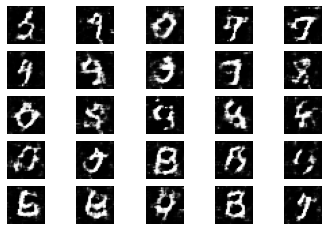

1501 [D loss: 0.673149, acc.: 60.94%] [G loss: 0.976530]
1502 [D loss: 0.413357, acc.: 77.73%] [G loss: 0.813580]
1503 [D loss: 0.333349, acc.: 90.23%] [G loss: 0.944805]
1504 [D loss: 0.234062, acc.: 92.97%] [G loss: 0.954425]
1505 [D loss: 0.445222, acc.: 80.47%] [G loss: 0.885496]
1506 [D loss: 0.677547, acc.: 57.03%] [G loss: 0.867405]
1507 [D loss: 0.664173, acc.: 62.89%] [G loss: 0.947482]
1508 [D loss: 0.476000, acc.: 78.52%] [G loss: 0.838703]
1509 [D loss: 0.237740, acc.: 94.53%] [G loss: 0.903453]
1510 [D loss: 0.485165, acc.: 78.12%] [G loss: 0.943605]
1511 [D loss: 0.704174, acc.: 57.03%] [G loss: 0.975693]
1512 [D loss: 0.503729, acc.: 75.39%] [G loss: 0.918797]
1513 [D loss: 0.514669, acc.: 76.56%] [G loss: 0.923202]
1514 [D loss: 0.519251, acc.: 75.39%] [G loss: 0.994855]
1515 [D loss: 1.092070, acc.: 30.86%] [G loss: 1.013328]
1516 [D loss: 0.956007, acc.: 41.41%] [G loss: 0.873983]
1517 [D loss: 0.467834, acc.: 78.52%] [G loss: 0.873841]
1518 [D loss: 0.707741, acc.: 5

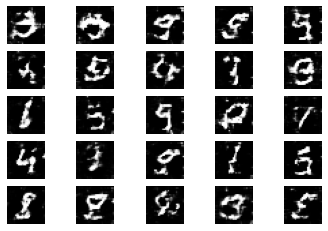

1551 [D loss: 0.546606, acc.: 73.44%] [G loss: 0.902341]
1552 [D loss: 0.600543, acc.: 64.84%] [G loss: 0.895220]
1553 [D loss: 0.498692, acc.: 78.12%] [G loss: 0.906305]
1554 [D loss: 1.226466, acc.: 49.22%] [G loss: 0.982711]
1555 [D loss: 0.536906, acc.: 72.66%] [G loss: 0.804630]
1556 [D loss: 0.284471, acc.: 92.58%] [G loss: 0.810010]
1557 [D loss: 0.647882, acc.: 65.62%] [G loss: 0.860943]
1558 [D loss: 0.197967, acc.: 96.48%] [G loss: 0.879577]
1559 [D loss: 0.197164, acc.: 94.53%] [G loss: 1.034429]
1560 [D loss: 0.156950, acc.: 98.83%] [G loss: 1.138054]
1561 [D loss: 0.563698, acc.: 70.31%] [G loss: 0.924590]
1562 [D loss: 0.442399, acc.: 75.00%] [G loss: 0.768964]
1563 [D loss: 0.126104, acc.: 99.61%] [G loss: 0.896021]
1564 [D loss: 0.220490, acc.: 92.19%] [G loss: 1.168865]
1565 [D loss: 1.144668, acc.: 29.30%] [G loss: 1.008074]
1566 [D loss: 0.384493, acc.: 82.03%] [G loss: 0.891943]
1567 [D loss: 0.241208, acc.: 95.70%] [G loss: 0.905982]
1568 [D loss: 0.279139, acc.: 9

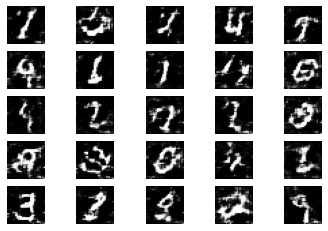

1601 [D loss: 0.232852, acc.: 94.14%] [G loss: 0.983943]
1602 [D loss: 0.288661, acc.: 90.23%] [G loss: 0.794419]
1603 [D loss: 0.464415, acc.: 78.52%] [G loss: 0.751649]
1604 [D loss: 0.368367, acc.: 81.64%] [G loss: 0.965341]
1605 [D loss: 0.481930, acc.: 75.78%] [G loss: 0.824119]
1606 [D loss: 0.168280, acc.: 96.88%] [G loss: 1.023168]
1607 [D loss: 0.066742, acc.: 100.00%] [G loss: 1.021110]
1608 [D loss: 0.140205, acc.: 95.70%] [G loss: 1.150499]
1609 [D loss: 0.063875, acc.: 99.61%] [G loss: 1.053952]
1610 [D loss: 0.087685, acc.: 100.00%] [G loss: 0.987655]
1611 [D loss: 0.040240, acc.: 99.61%] [G loss: 0.803519]
1612 [D loss: 0.098571, acc.: 99.61%] [G loss: 0.800931]
1613 [D loss: 0.203306, acc.: 94.14%] [G loss: 0.716547]
1614 [D loss: 0.127478, acc.: 98.83%] [G loss: 0.841075]
1615 [D loss: 0.218499, acc.: 96.48%] [G loss: 0.879782]
1616 [D loss: 0.183666, acc.: 95.70%] [G loss: 1.037430]
1617 [D loss: 0.711219, acc.: 60.16%] [G loss: 0.837830]
1618 [D loss: 0.262476, acc.:

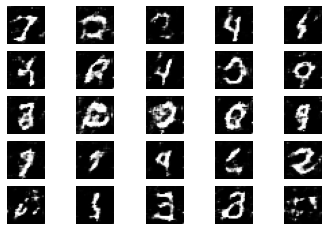

1651 [D loss: 0.533240, acc.: 73.05%] [G loss: 0.922940]
1652 [D loss: 0.411274, acc.: 79.30%] [G loss: 1.035276]
1653 [D loss: 0.580479, acc.: 66.02%] [G loss: 0.996812]
1654 [D loss: 0.199580, acc.: 98.44%] [G loss: 0.922650]
1655 [D loss: 0.223722, acc.: 96.48%] [G loss: 0.913181]
1656 [D loss: 0.139539, acc.: 98.44%] [G loss: 1.014553]
1657 [D loss: 0.246214, acc.: 94.14%] [G loss: 0.978894]
1658 [D loss: 0.550314, acc.: 71.48%] [G loss: 0.853417]
1659 [D loss: 0.624188, acc.: 62.11%] [G loss: 0.854122]
1660 [D loss: 0.481140, acc.: 80.08%] [G loss: 0.939991]
1661 [D loss: 0.150171, acc.: 98.83%] [G loss: 1.015575]
1662 [D loss: 0.305365, acc.: 88.28%] [G loss: 1.023092]
1663 [D loss: 0.136936, acc.: 98.05%] [G loss: 0.818592]
1664 [D loss: 0.156038, acc.: 98.44%] [G loss: 0.938496]
1665 [D loss: 0.346982, acc.: 81.25%] [G loss: 0.996729]
1666 [D loss: 0.123624, acc.: 97.66%] [G loss: 0.886504]
1667 [D loss: 0.119265, acc.: 98.44%] [G loss: 0.739922]
1668 [D loss: 0.215737, acc.: 9

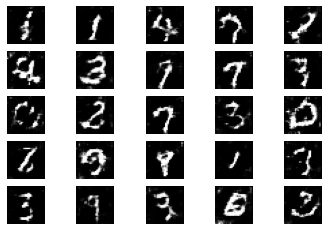

1701 [D loss: 0.378684, acc.: 86.72%] [G loss: 1.012722]
1702 [D loss: 0.166441, acc.: 96.88%] [G loss: 0.968093]
1703 [D loss: 0.125568, acc.: 98.44%] [G loss: 0.894233]
1704 [D loss: 0.313895, acc.: 89.45%] [G loss: 0.972425]
1705 [D loss: 0.184423, acc.: 95.70%] [G loss: 0.961785]
1706 [D loss: 0.221444, acc.: 93.75%] [G loss: 0.841743]
1707 [D loss: 0.085993, acc.: 99.22%] [G loss: 0.929139]
1708 [D loss: 0.305508, acc.: 90.23%] [G loss: 0.941832]
1709 [D loss: 0.445306, acc.: 78.12%] [G loss: 0.949100]
1710 [D loss: 0.074497, acc.: 100.00%] [G loss: 1.037276]
1711 [D loss: 0.267580, acc.: 93.75%] [G loss: 1.048820]
1712 [D loss: 0.268664, acc.: 93.75%] [G loss: 0.953744]
1713 [D loss: 0.124983, acc.: 96.88%] [G loss: 1.074527]
1714 [D loss: 0.194423, acc.: 95.70%] [G loss: 1.006664]
1715 [D loss: 0.120729, acc.: 99.22%] [G loss: 0.758486]
1716 [D loss: 0.118150, acc.: 98.83%] [G loss: 0.823837]
1717 [D loss: 0.106124, acc.: 97.66%] [G loss: 0.775223]
1718 [D loss: 0.179314, acc.: 

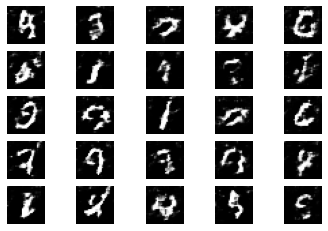

1751 [D loss: 1.199981, acc.: 26.17%] [G loss: 0.979420]
1752 [D loss: 0.613364, acc.: 64.84%] [G loss: 1.067083]
1753 [D loss: 1.613222, acc.: 18.75%] [G loss: 1.090358]
1754 [D loss: 0.903772, acc.: 45.31%] [G loss: 1.101556]
1755 [D loss: 0.732287, acc.: 60.16%] [G loss: 1.177709]
1756 [D loss: 0.280974, acc.: 89.45%] [G loss: 1.050644]
1757 [D loss: 0.106908, acc.: 99.61%] [G loss: 1.101311]
1758 [D loss: 0.078082, acc.: 100.00%] [G loss: 1.166639]
1759 [D loss: 0.051045, acc.: 100.00%] [G loss: 1.217372]
1760 [D loss: 0.025955, acc.: 100.00%] [G loss: 1.026236]
1761 [D loss: 0.012326, acc.: 100.00%] [G loss: 1.090979]
1762 [D loss: 0.024337, acc.: 100.00%] [G loss: 0.878281]
1763 [D loss: 0.032602, acc.: 100.00%] [G loss: 0.785772]
1764 [D loss: 0.261099, acc.: 88.28%] [G loss: 0.717735]
1765 [D loss: 0.203171, acc.: 93.75%] [G loss: 0.879420]
1766 [D loss: 0.049661, acc.: 100.00%] [G loss: 0.924787]
1767 [D loss: 0.130609, acc.: 97.66%] [G loss: 0.798927]
1768 [D loss: 0.199118, 

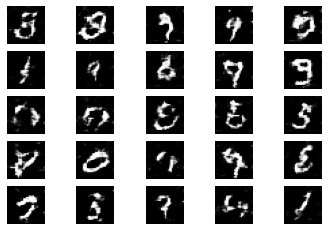

1801 [D loss: 0.095601, acc.: 99.22%] [G loss: 0.871735]
1802 [D loss: 0.040044, acc.: 100.00%] [G loss: 0.949266]
1803 [D loss: 0.309641, acc.: 89.45%] [G loss: 0.943365]
1804 [D loss: 0.184295, acc.: 93.75%] [G loss: 0.721472]
1805 [D loss: 0.132092, acc.: 99.61%] [G loss: 0.972373]
1806 [D loss: 0.070229, acc.: 99.61%] [G loss: 1.049502]
1807 [D loss: 0.091050, acc.: 98.83%] [G loss: 1.015929]
1808 [D loss: 0.060817, acc.: 100.00%] [G loss: 1.063859]
1809 [D loss: 0.039762, acc.: 99.61%] [G loss: 1.022309]
1810 [D loss: 0.217517, acc.: 93.36%] [G loss: 1.037477]
1811 [D loss: 0.100076, acc.: 98.44%] [G loss: 0.876341]
1812 [D loss: 0.188729, acc.: 94.92%] [G loss: 0.815651]
1813 [D loss: 0.123798, acc.: 99.61%] [G loss: 0.853609]
1814 [D loss: 0.171086, acc.: 97.66%] [G loss: 0.904474]
1815 [D loss: 0.147013, acc.: 98.05%] [G loss: 0.947560]
1816 [D loss: 0.290836, acc.: 92.58%] [G loss: 0.846556]
1817 [D loss: 0.120125, acc.: 99.22%] [G loss: 0.890203]
1818 [D loss: 0.203900, acc.:

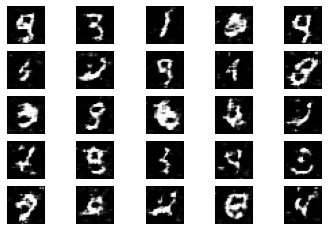

1851 [D loss: 0.195519, acc.: 94.53%] [G loss: 0.915428]
1852 [D loss: 0.062833, acc.: 99.61%] [G loss: 1.068354]
1853 [D loss: 0.124581, acc.: 98.44%] [G loss: 0.993440]
1854 [D loss: 0.055177, acc.: 100.00%] [G loss: 1.335322]
1855 [D loss: 0.308490, acc.: 88.28%] [G loss: 1.044581]
1856 [D loss: 0.036001, acc.: 100.00%] [G loss: 1.405262]
1857 [D loss: 0.173238, acc.: 94.53%] [G loss: 1.452856]
1858 [D loss: 0.063579, acc.: 99.22%] [G loss: 1.341886]
1859 [D loss: 0.030465, acc.: 100.00%] [G loss: 1.106969]
1860 [D loss: 0.030875, acc.: 100.00%] [G loss: 1.096922]
1861 [D loss: 0.078601, acc.: 99.61%] [G loss: 0.910837]
1862 [D loss: 0.041996, acc.: 100.00%] [G loss: 0.930707]
1863 [D loss: 0.079652, acc.: 100.00%] [G loss: 1.037373]
1864 [D loss: 0.336935, acc.: 85.94%] [G loss: 0.932008]
1865 [D loss: 0.033119, acc.: 100.00%] [G loss: 1.063162]
1866 [D loss: 0.116844, acc.: 98.44%] [G loss: 0.921811]
1867 [D loss: 0.033821, acc.: 100.00%] [G loss: 1.059263]
1868 [D loss: 0.115023,

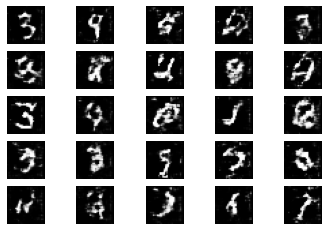

1901 [D loss: 0.086103, acc.: 98.05%] [G loss: 0.715031]
1902 [D loss: 0.113782, acc.: 98.83%] [G loss: 0.953026]
1903 [D loss: 0.068450, acc.: 99.22%] [G loss: 0.865299]
1904 [D loss: 0.098287, acc.: 97.66%] [G loss: 1.141954]
1905 [D loss: 0.050746, acc.: 99.22%] [G loss: 0.915852]
1906 [D loss: 0.025605, acc.: 100.00%] [G loss: 0.919899]
1907 [D loss: 0.027132, acc.: 100.00%] [G loss: 0.933508]
1908 [D loss: 0.027269, acc.: 100.00%] [G loss: 0.851867]
1909 [D loss: 0.041506, acc.: 99.61%] [G loss: 0.700629]
1910 [D loss: 0.029229, acc.: 100.00%] [G loss: 0.888405]
1911 [D loss: 0.061030, acc.: 99.61%] [G loss: 0.797864]
1912 [D loss: 0.148646, acc.: 97.66%] [G loss: 0.902170]
1913 [D loss: 0.268496, acc.: 92.97%] [G loss: 0.965400]
1914 [D loss: 0.198098, acc.: 92.58%] [G loss: 1.131695]
1915 [D loss: 0.049358, acc.: 100.00%] [G loss: 1.103256]
1916 [D loss: 0.074842, acc.: 99.61%] [G loss: 0.856218]
1917 [D loss: 0.159022, acc.: 96.09%] [G loss: 1.014248]
1918 [D loss: 0.048780, ac

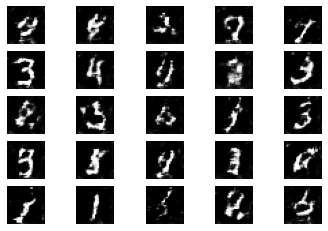

1951 [D loss: 0.023626, acc.: 100.00%] [G loss: 1.086607]
1952 [D loss: 0.010494, acc.: 100.00%] [G loss: 0.820993]
1953 [D loss: 0.012834, acc.: 100.00%] [G loss: 0.822782]
1954 [D loss: 0.014055, acc.: 100.00%] [G loss: 0.890592]
1955 [D loss: 0.009945, acc.: 100.00%] [G loss: 0.990652]
1956 [D loss: 0.018133, acc.: 100.00%] [G loss: 0.788409]
1957 [D loss: 0.015561, acc.: 100.00%] [G loss: 0.758504]
1958 [D loss: 0.022956, acc.: 100.00%] [G loss: 0.784843]
1959 [D loss: 0.017130, acc.: 100.00%] [G loss: 1.104655]
1960 [D loss: 0.030909, acc.: 100.00%] [G loss: 1.063942]
1961 [D loss: 0.011556, acc.: 100.00%] [G loss: 0.916855]
1962 [D loss: 0.006442, acc.: 99.61%] [G loss: 1.012657]
1963 [D loss: 0.016986, acc.: 100.00%] [G loss: 0.876833]
1964 [D loss: 0.014240, acc.: 100.00%] [G loss: 0.932086]
1965 [D loss: 0.005594, acc.: 100.00%] [G loss: 1.053989]
1966 [D loss: 0.017128, acc.: 100.00%] [G loss: 1.029675]
1967 [D loss: 0.018047, acc.: 99.61%] [G loss: 0.751612]
1968 [D loss: 0.

In [4]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=2000, batch_size=128, save_interval=50)
